In [1]:
import os
import re
import yaml

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from numpy import asarray

In [2]:
# I/O
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))
seg = pd.read_parquet(os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_clustering_3d_leiden.parquet'))
cols = [i.split('_nucleiRingMask')[0] for i in seg.columns]
seg.columns = cols

out = os.path.join(os.getcwd(), 'output/umap_channels')
if not os.path.exists(out):
    os.makedirs(out)

In [3]:
# stylized marker names
ch_dict = {
    'anti_CD3': 'CD3\u03B5', 'anti_CD45RO': 'CD45RO', 'Keratin_570': 'Keratin', 'aSMA_660': '\u03B1SMA',
    'CD4_488': 'CD4', 'CD45_PE': 'CD45', 'PD1_647': 'PD1', 'CD20_488': 'CD20', 'CD68_555': 'CD68',
    'CD8a_660': 'CD8\u03B1', 'CD163_488': 'CD163', 'FOXP3_570': 'FOXP3', 'PDL1_647': 'PDL1',
    'Ecad_488': 'ECAD', 'Vimentin_555': 'Vimentin', 'CDX2_647': 'CDX2', 'LaminABC_488': 'LaminABC',
    'Desmin_555': 'Desmin', 'CD31_647': 'CD31', 'PCNA_488': 'PCNA', 'CollagenIV_647': 'CollagenIV'
}

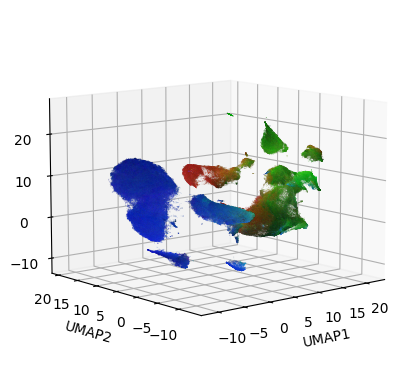

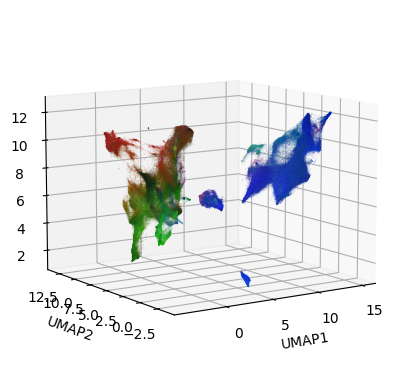

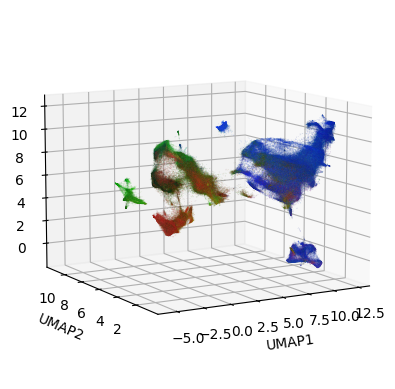

In [4]:
# generate individual channel PNG image files
for name, emb, data in zip(['Seg', 'VAE9_VIG7', 'VAE30'], ['emb', 'VAE9_VIG7_emb', 'VAE30_emb'], [seg, main, main]):
    if not os.path.exists(os.path.join(out, f'tricolor_{name}.png')):
        
        for c, ch in zip(['blue', 'red', 'green'], ['Keratin_570', 'aSMA_660', 'CD45_PE']):
            data[f'{c}_norm'] = (data[ch] - data[ch].min()) / (data[ch].max() - data[ch].min())
        
        # combine normalized RGB values into a single column representing colors
        data['color'] = data.apply(lambda row: (row['red_norm'], row['green_norm'], row['blue_norm']), axis=1)
    
        fig = plt.figure()
        ax = plt.axes(projection='3d', computed_zorder=False)

        if name == 'Seg':
            ax.view_init(elev=10, azim=230)
        elif name == 'VAE9_VIG7':
            ax.view_init(elev=10, azim=236)
        elif name == 'VAE30':
            ax.view_init(elev=10, azim=240)

        ax.scatter(
            data[f'{emb}1'],
            data[f'{emb}2'],
            data[f'{emb}3'],
            c=data['color'], linewidth=0.1,
            s=150000 / len(data), alpha=0.1
        )

        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')
        ax.set_zlabel('UMAP3')
        ax.axis('auto')
        ax.tick_params(labelsize=10)
        ax.grid(True)
    
        plt.savefig(
            os.path.join(out, f'tricolor_{name}.png'), bbox_inches='tight', dpi=800
        )
        plt.show()
        plt.close('all')

Seg embeddings


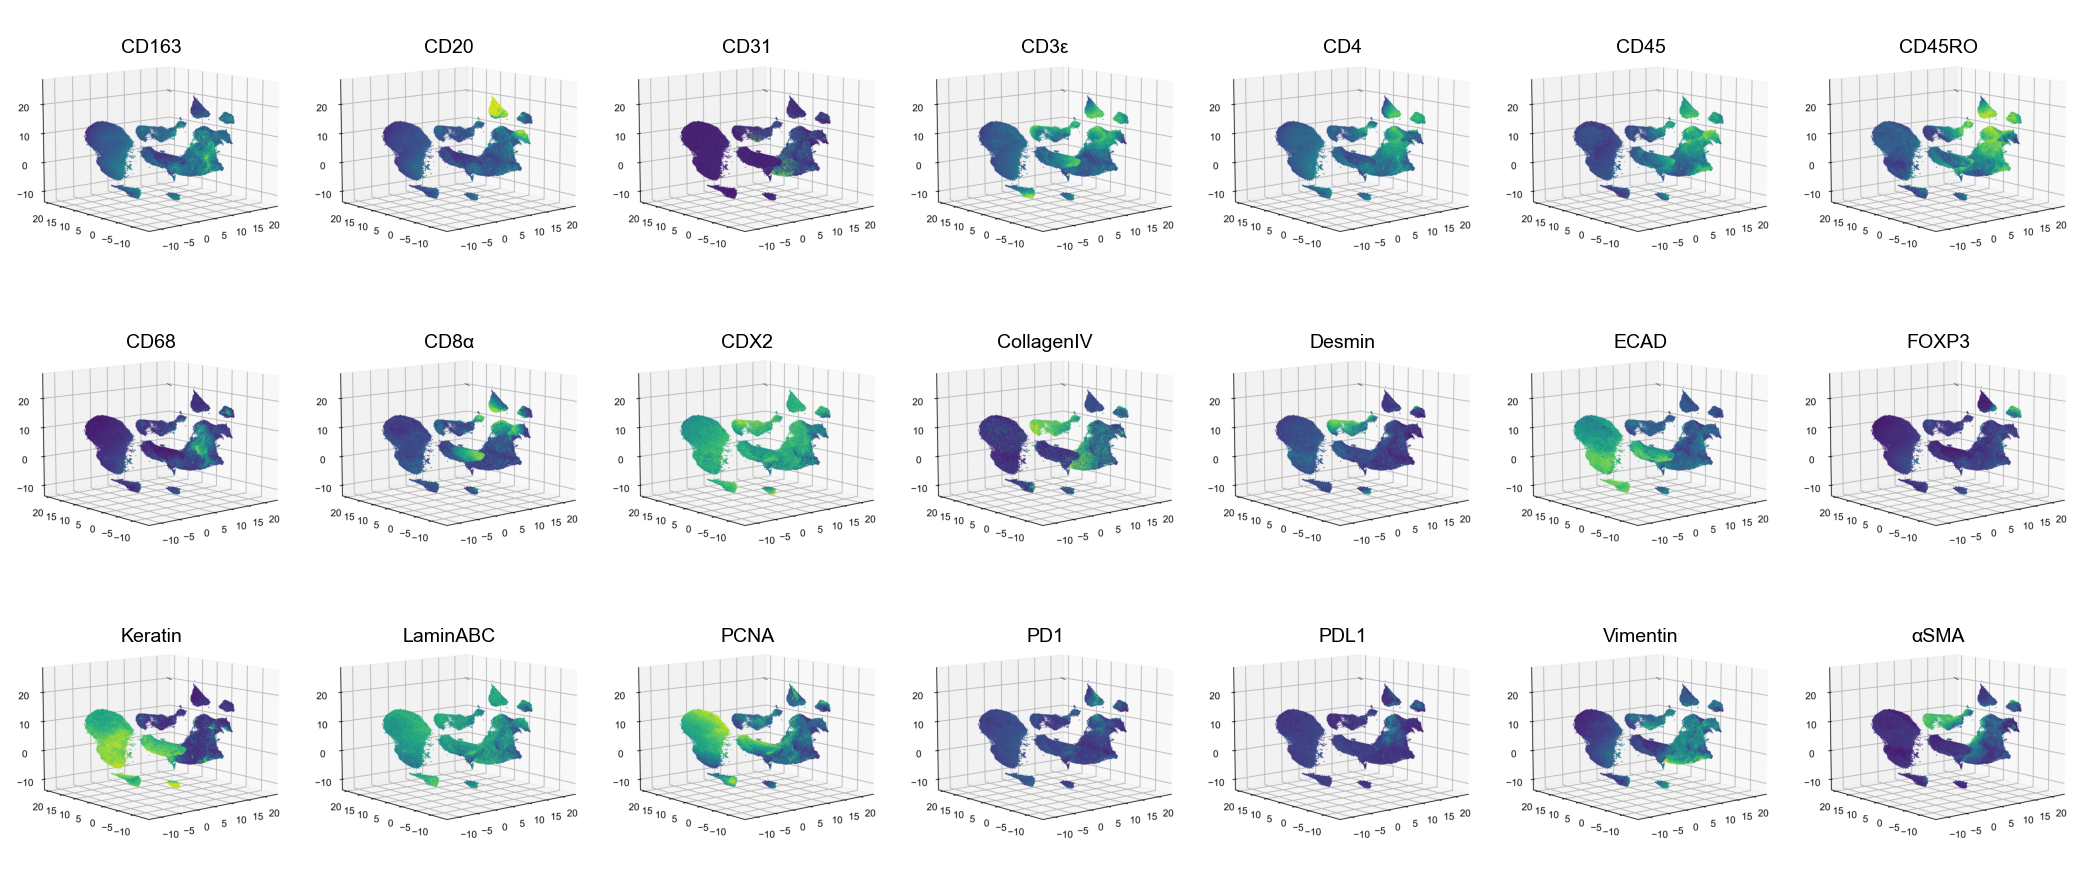


VAE9_VIG7 embeddings


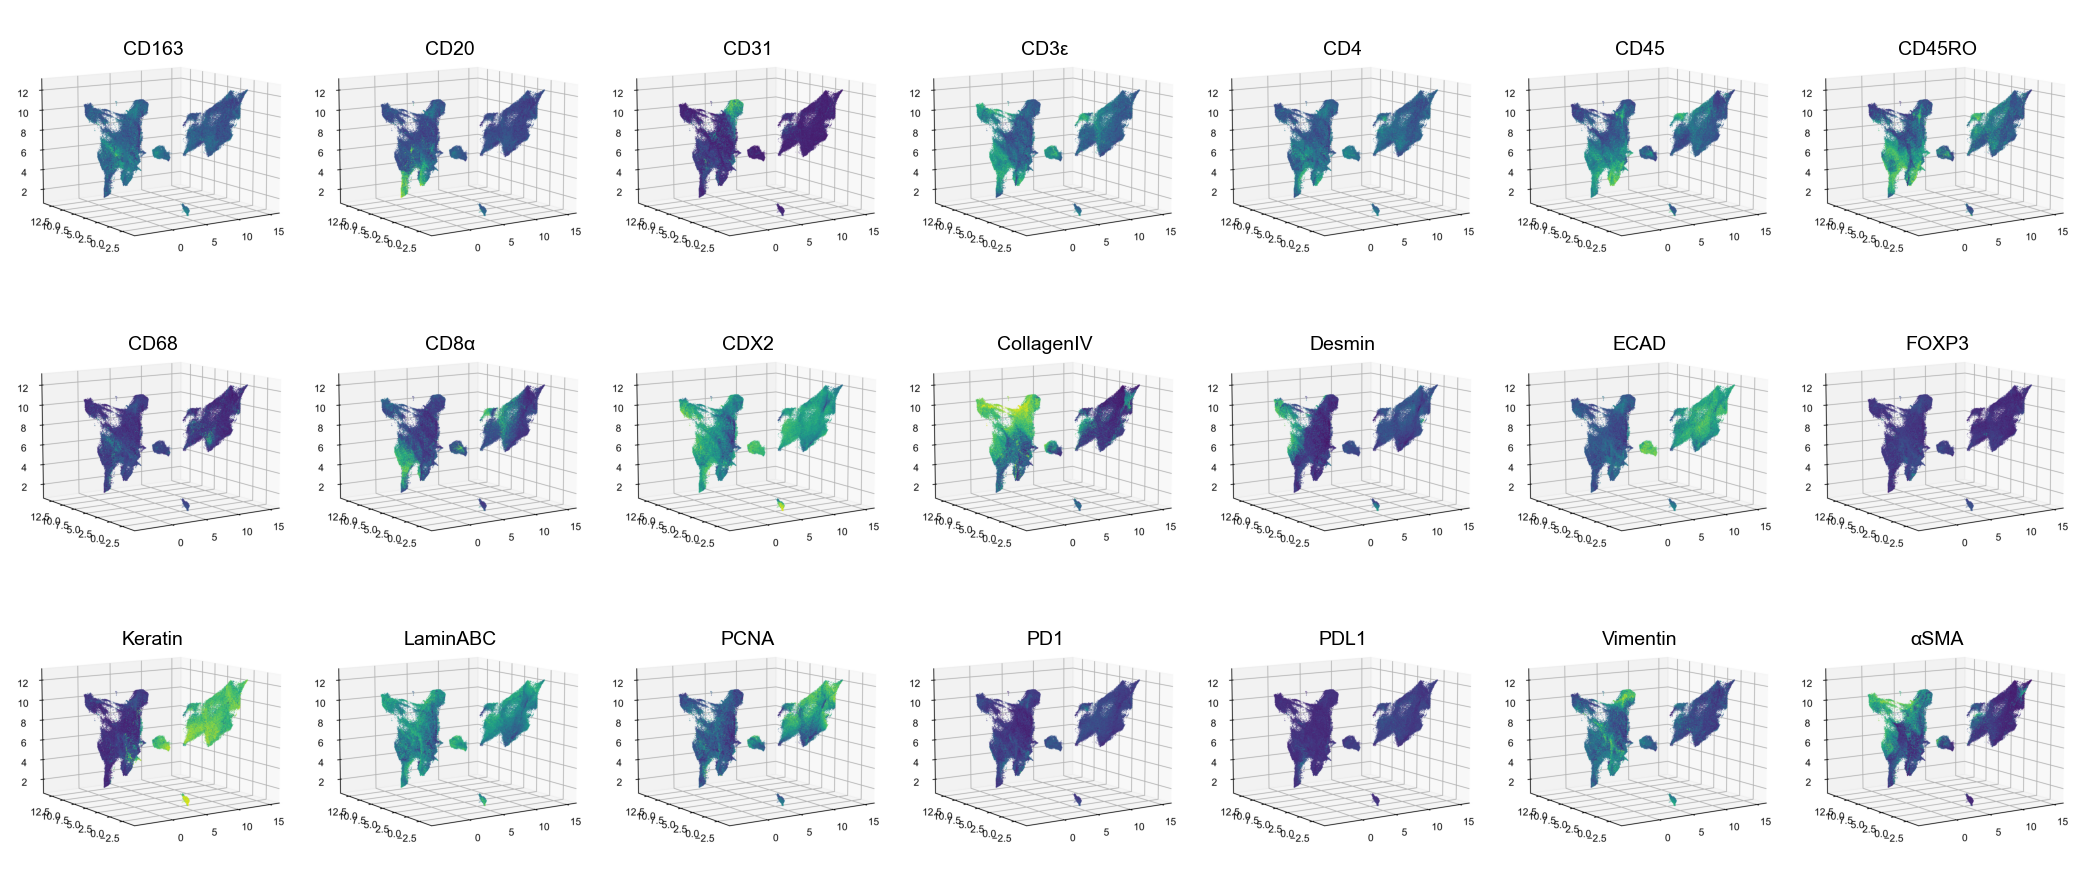


VAE30 embeddings


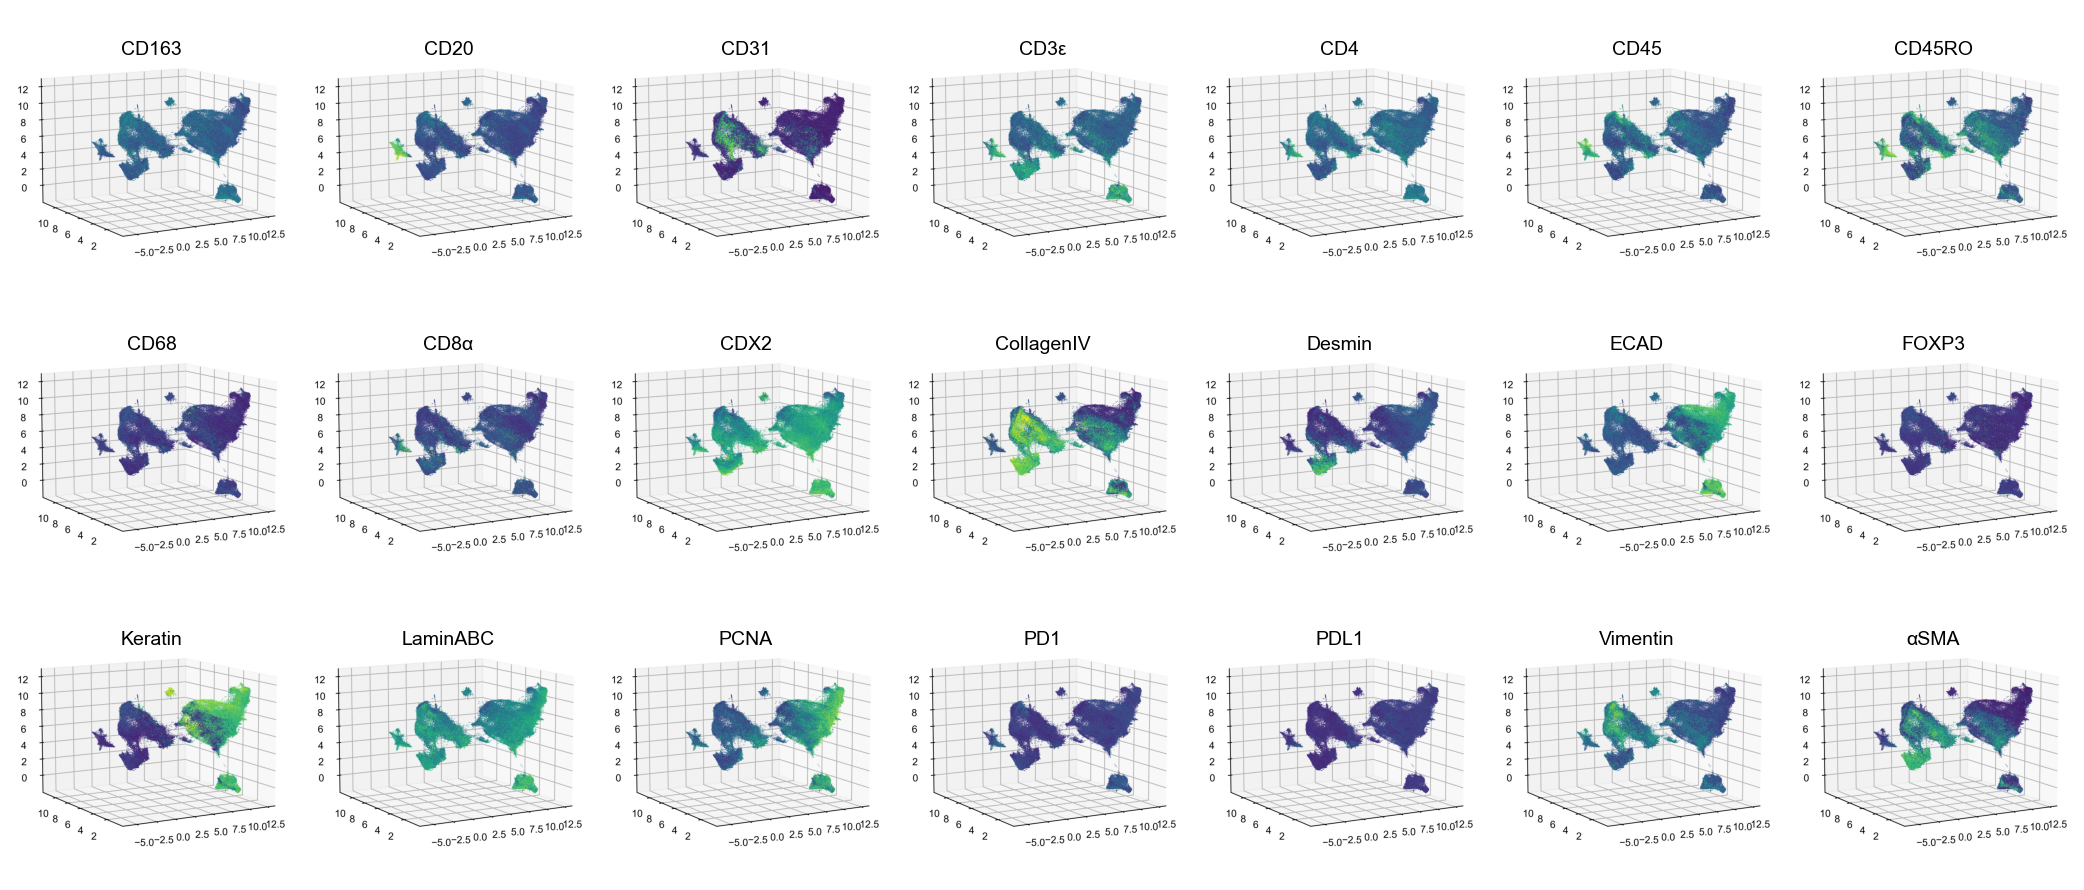

In [5]:
plt.rcParams['font.family'] = 'Arial'

for name, emb in zip(['Seg', 'VAE9_VIG7', 'VAE30'], ['Seg_emb', 'VAE9_VIG7_emb', 'VAE30_emb']):

    print(f'{name} embeddings')

    # generate individual channel PNG image files
    for ch in ch_dict.keys():
        if not os.path.exists(os.path.join(out, f'{ch}_{name}.png')):
            
            fig = plt.figure()
            ax = plt.axes(projection='3d', computed_zorder=False)
            
            if name == 'Seg':
                ax.view_init(elev=10, azim=230)
            elif name == 'VAE9_VIG7':
                ax.view_init(elev=10, azim=236)
            elif name == 'VAE30':
                ax.view_init(elev=10, azim=240)
            
            ax.scatter(
                main[f'{emb}1'],
                main[f'{emb}2'],
                main[f'{emb}3'],
                c=main[ch], linewidth=0.1,
                s=150000 / len(main)
            )
            ax.axis('auto')
            ax.tick_params(labelsize=10)
            ax.grid(True)
            plt.savefig(
                os.path.join(out, f"{ch}_{name}.png"), bbox_inches='tight', dpi=800
            )
            plt.close('all')
    
    # generate facetgrid showing all plots together
    data_melt = (
        main[list(ch_dict.keys()) + [f'{emb}1', f'{emb}2', f'{emb}3']]
        .sample(frac=0.1)
        .reset_index(drop=True)
        .melt(id_vars=[f'{emb}1', f'{emb}2', f'{emb}3'], var_name='abx')
    )

    long_table = pd.DataFrame(columns=['channel', 'image'])
    for e, file in enumerate(os.listdir(out)):
        if (name in file and not file.startswith('.') and not file.endswith(f'combined_{name}.png') 
            and not file.endswith(f'tricolor_{name}.png')):
            channel_name = ch_dict[file.split(f'_{name}.png')[0]]
            img = Image.open(os.path.join(out, file))
            arr = asarray(img)
            long_table.loc[e, 'channel'] = channel_name
            long_table.loc[e, 'image'] = arr
    
    long_table.sort_values(by='channel', inplace=True)
    
    g = sns.FacetGrid(
        long_table, col='channel', col_wrap=7, sharex=False, sharey=False,
        height=3.0, aspect=1.0
    )
    g.map(
        lambda image, **kwargs: (plt.imshow(image.values[0]), plt.grid(False)), 'image'
    )
    
    for ax in g.axes.flatten():
        ax.axis('off')
    
    g.set_titles(col_template="{col_name}", size=14, fontweight='normal', y=0.81)
    
    g.fig.tight_layout()
    
    plt.savefig(
        os.path.join(out, f'combined_{name}.png'), bbox_inches='tight', dpi=800
    )
    plt.show()
    plt.close('all')
    
    print()